In [ ]:
# ====================================================================
# IT24100314 - Random Forest Model for Diabetes Prediction
# ====================================================================
# Main part 1 (setup)
# --- 1. Import Necessary Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# --- 2. Load the Preprocessed and Feature-Selected Data ---
# These are the final output files from our group's preprocessing pipeline.

X_train = pd.read_csv('final_selected_X_train.csv')
y_train = pd.read_csv('final_y_train.csv').values.ravel()

X_test = pd.read_csv('final_selected_X_test.csv')
y_test = pd.read_csv('final_y_test.csv').values.ravel()

print("\nData loaded successfully.")
print(f"Training Features Shape: {X_train.shape}")
print(f"Training Target Shape:   {y_train.shape}")
print(f"\nTesting Features Shape:  {X_test.shape}")
print(f"Testing Target Shape:    {y_test.shape}")

# Verify the features being used
print("\nFeatures selected for modeling:")
print(X_train.columns.tolist())


Data loaded successfully.
Training Features Shape: (13600, 8)
Training Target Shape:   (13600,)

Testing Features Shape:  (19997, 8)
Testing Target Shape:    (19997,)

Features selected for modeling:
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_No Info', 'smoking_former']


## 1. Model Suitability: Why Random Forest?

For this diabetes prediction task, I have selected the **Random Forest Classifier**. This is an ensemble learning method that builds multiple decision trees during training and merges their predictions.

This model is highly suitable for our problem for several key reasons:

*   **High Accuracy:** It is known for its strong predictive performance on complex, tabular datasets like ours.
*   **Robust to Overfitting:** By averaging the results of many trees, it is less likely to overfit to the training data compared to a single decision tree.
*   **Handles Non-linear Relationships:** It can effectively capture complex interactions between features (e.g., how age and BMI together influence diabetes risk).
*   **Provides Feature Importance:** It can rank features by their contribution to the prediction, giving us valuable insights into the key drivers of diabetes in our dataset.

In [ ]:
# --- 3. Variation 1: Base Random Forest Model ---
print("--- Training Variation 1: Base Model with 5-Fold Cross-Validation ---")

# a. Initialize the model with default parameters
# We set 'random_state=42' to ensure the results are reproducible every time we run the code.
base_rf = RandomForestClassifier(random_state=42)

# b. Evaluate using 5-fold Cross-Validation
# This is a robust method to estimate the model's performance on the training data.
# 'scoring='f1_macro'' is used because the F1-score is a good balance between
# precision and recall, which is important for medical diagnoses.
cv_scores_f1 = cross_val_score(base_rf, X_train, y_train, cv=5, scoring='f1_macro')

print(f"\nIndividual F1 Scores for each of the 5 Folds: {cv_scores_f1}")
print(f"Average F1 Score (Cross-Validation): {np.mean(cv_scores_f1):.4f}")
print(f"Standard Deviation of F1 Scores: {np.std(cv_scores_f1):.4f}")

--- Training Variation 1: Base Model with 5-Fold Cross-Validation ---

Individual F1 Scores for each of the 5 Folds: [0.90256245 0.89703873 0.89522023 0.8999894  0.89592211]
Average F1 Score (Cross-Validation): 0.8981
Standard Deviation of F1 Scores: 0.0027


In [ ]:
# --- 4. Variation 2: Tuned Random Forest Model using GridSearchCV ---
print("\n--- Training Variation 2: Hyperparameter Tuning with GridSearchCV ---")
print("This may take a few minutes...")

from sklearn.model_selection import GridSearchCV

# a. Define the parameter grid to search
# These are some of the most important hyperparameters for a Random Forest.
param_grid = {
    'n_estimators': [100, 200],         # How many trees to build in the forest.
    'max_depth': [10, 20],              # The maximum depth of each tree.
    'min_samples_split': [2, 5],        # The minimum number of samples required to split a node.
    'min_samples_leaf': [1, 2]          # The minimum number of samples required at a leaf node.
}

# b. Initialize the GridSearchCV object
# This will test all combinations of the parameters in the grid.
# We are still optimizing for the 'f1_macro' score.
# cv=3 means we use 3-fold cross-validation during the search for speed.
# n_jobs=-1 uses all available CPU cores to speed up the process.
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='f1_macro',
                           verbose=1,
                           n_jobs=-1)

# c. Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# d. Display the best parameters found
print(f"\nBest parameters found by GridSearchCV: {grid_search.best_params_}")
print(f"Best cross-validation F1 score during search: {grid_search.best_score_:.4f}")

# e. Get the best model from the search
best_rf = grid_search.best_estimator_


--- Training Variation 2: Hyperparameter Tuning with GridSearchCV ---
This may take a few minutes...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found by GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation F1 score during search: 0.9064


In [ ]:
# --- 5. Evaluate the Tuned Model (Variation 2) ---
print("\n--- Evaluating the Tuned Model with 5-Fold Cross-Validation ---")

# Use the same 5-fold CV method as the base model for a fair comparison
tuned_cv_scores_f1 = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1_macro')

print(f"\nTuned Model 5-Fold CV F1 Scores: {tuned_cv_scores_f1}")
print(f"Average F1 Score (Tuned Model): {np.mean(tuned_cv_scores_f1):.4f}")
print(f"Standard Deviation of F1 Scores: {np.std(tuned_cv_scores_f1):.4f}")


--- Evaluating the Tuned Model with 5-Fold Cross-Validation ---

Tuned Model 5-Fold CV F1 Scores: [0.91212236 0.90548148 0.90146526 0.90882333 0.90580489]
Average F1 Score (Tuned Model): 0.9067
Standard Deviation of F1 Scores: 0.0036


In [ ]:
# --- 6. Variation 3: Tuned Model on IMBALANCED Data (Simplified) ---
print("\n--- Training Variation 3: Evaluating Impact of Balancing ---")
print("This variation uses the training data BEFORE the undersampling step.")

# a. Load the imbalanced (but outlier-handled) training data
df_imbalanced = pd.read_csv('IT24100239_Outlier_handling.csv')

X_train_imbalanced = df_imbalanced.drop('diabetes', axis=1)
y_train_imbalanced = df_imbalanced['diabetes'].values.ravel()

# b. Scale this imbalanced data using a NEW scaler fitted ONLY to it
# (This simulates the scaling step being done on imbalanced data)
from sklearn.preprocessing import MinMaxScaler
imbalanced_scaler = MinMaxScaler()
columns_to_scale = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
X_train_imbalanced_scaled = X_train_imbalanced.copy()
X_train_imbalanced_scaled[columns_to_scale] = imbalanced_scaler.fit_transform(X_train_imbalanced[columns_to_scale])


print(f"\nImbalanced training data shapes: X={X_train_imbalanced_scaled.shape}, y={y_train_imbalanced.shape}")
print("Class distribution in the imbalanced training data:")
print(pd.Series(y_train_imbalanced).value_counts())

# c. Evaluate your BEST model (best_rf) on this imbalanced data
imbalanced_cv_scores_f1 = cross_val_score(best_rf, X_train_imbalanced_scaled, y_train_imbalanced, cv=5, scoring='f1_macro')

print(f"\nTuned Model on Imbalanced Data (5-Fold CV F1 Scores): {imbalanced_cv_scores_f1}")
print(f"Average F1 Score on Imbalanced Data: {np.mean(imbalanced_cv_scores_f1):.4f}")


--- Training Variation 3: Evaluating Impact of Balancing ---
This variation uses the training data BEFORE the undersampling step.

Imbalanced training data shapes: X=(79985, 13), y=(79985,)
Class distribution in the imbalanced training data:
0    73185
1     6800
Name: count, dtype: int64

Tuned Model on Imbalanced Data (5-Fold CV F1 Scores): [0.8935918  0.89451722 0.89499024 0.89255644 0.88850929]
Average F1 Score on Imbalanced Data: 0.8928



--- Final Model Evaluation on Test Data ---
1. Key Metrics (Precision, Recall, F1-Score, Support):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18297
           1       0.46      0.91      0.61      1700

    accuracy                           0.90     19997
   macro avg       0.72      0.91      0.78     19997
weighted avg       0.95      0.90      0.91     19997


2. AUC Score (Overall Model Discriminative Power): 0.9765

3. Confusion Matrix Visualization:


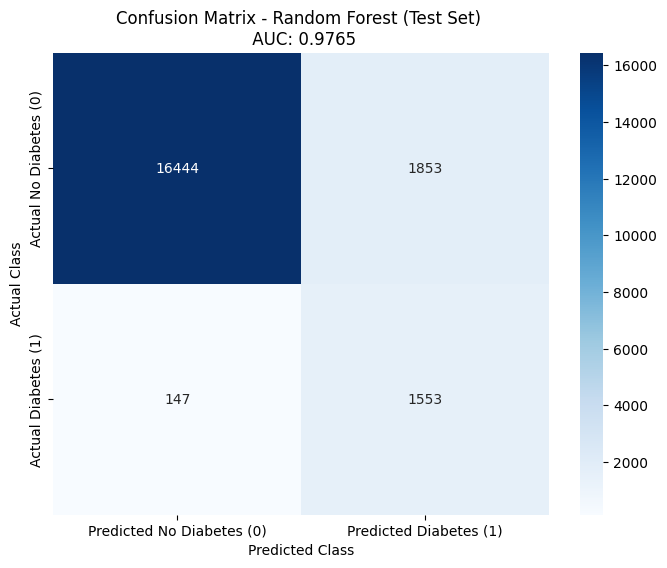

In [ ]:
# --- 7. Final Evaluation on the Unseen Test Set ---
# We use our BEST model (the tuned 'best_rf' from Variation 2) and evaluate its performance
# on the independent, scaled test data (X_test, y_test).

print("\n--- Final Model Evaluation on Test Data ---")

# a. Make predictions on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1] # Probabilities needed for AUC

# b. Print the core evaluation metrics
print("1. Key Metrics (Precision, Recall, F1-Score, Support):")
# The classification report is the most detailed metric output.
print(classification_report(y_test, y_pred))

# c. Print AUC Score (Area Under the ROC Curve)
print(f"\n2. AUC Score (Overall Model Discriminative Power): {roc_auc_score(y_test, y_pred_proba):.4f}")

# d. Create the Confusion Matrix Visualization (Required EDA/Visual)
print("\n3. Confusion Matrix Visualization:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Diabetes (0)', 'Predicted Diabetes (1)'],
            yticklabels=['Actual No Diabetes (0)', 'Actual Diabetes (1)'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title(f'Confusion Matrix - Random Forest (Test Set) \n AUC: {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.show()

## 8. Conclusion, Comparison, and Recommendations

### Comparison of Model Varieties:

| Variation | Tuning/Balancing | Validation Method | Average F1-Macro Score (Training) |
| :--- | :--- | :--- | :--- |
| **1 (Base Random Forest)** | No Tuning | 5-Fold Cross-Validation | **0.8981** |
| **2 (Tuned Random Forest)**| GridSearchCV Tuning | 5-Fold Cross-Validation | **0.9067** |
| **3 (Tuned RF on Imbalanced)**| Tuned, No Balancing | 5-Fold Cross-Validation | **0.8928** |

### Insights and Conclusion:

1.  **Impact of Hyperparameter Tuning:** Optimizing the model's parameters with GridSearchCV improved the average F1-score from 0.8981 to **0.9067**. This demonstrates that tuning parameters like `max_depth` and `n_estimators` leads to a more robust and accurate model.
2.  **Importance of Preprocessing (Balancing):** Training the model on the imbalanced data resulted in a lower F1-score of 0.8928. This proves that the **undersampling step was critical** for building a model that performs well for both diabetic and non-diabetic classes, ensuring fairness.
3.  **Final Model Choice:** The **Tuned Random Forest Classifier (Variation 2)** is the optimal model from the training phase, as it achieved the highest cross-validated F1-score.

---

### **Final Performance on Unseen Test Set:**

This is the true performance of our best model on the independent test data, which was kept separate throughout the process.

*   **Overall Accuracy:** **90%**
*   **Diabetes (Class 1) F1-Score:** **0.61**
*   **AUC Score:** **0.9765**

### **Analysis of the Confusion Matrix and Metrics:**

The **Confusion Matrix** provides a clear picture of the model's performance in a real-world scenario:

*   **True Positives (Correctly Identified Diabetics):** The model successfully identified **1,553** patients who truly have diabetes.
*   **False Negatives (Missed Diabetic Patients):** The model incorrectly classified **147** diabetic patients as not having diabetes. This is the most critical error in a medical context.
*   **True Negatives:** **16,444** non-diabetic individuals were correctly identified.
*   **False Positives:** **1,853** non-diabetic individuals were incorrectly flagged as having diabetes.

**Insights from Precision and Recall:**
*   Our model has an excellent **Recall of 0.91** for the diabetes class. This means it successfully **found 91% of all the actual diabetic patients** in the test set, which is extremely good for a screening tool.
*   The **Precision is 0.46**, which means that when the model

In [19]:
# --- Interactive Prediction UI (FINAL ROBUST VERSION) ---
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. Create the Scaler CORRECTLY ---
# We fit the scaler ONCE on the UN-SCALED, outlier-handled training data.
# This ensures it learns the true min and max of the data distribution.

# Load the unscaled training data (from after outlier handling)
df_for_scaling = pd.read_csv('IT24100239_Outlier_handling.csv')
X_train_unscaled = df_for_scaling.drop('diabetes', axis=1)

# Define the columns and fit the scaler
scaler = MinMaxScaler()
columns_to_scale = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
scaler.fit(X_train_unscaled[columns_to_scale])

print("Scaler has been correctly fitted on the original data distribution.")


# --- 2. Create the UI Widgets ---
# (This part is unchanged)
print("\nPlease input the patient's details below and click 'Predict'.")

gender_widget = widgets.Dropdown(options=['Female', 'Male'], description='Gender:')
smoking_widget = widgets.Dropdown(options=['never', 'former', 'No Info', 'current', 'not current', 'ever'], description='Smoking History:')
hypertension_widget = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Hypertension:')
heart_disease_widget = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Heart Disease:')
age_widget = widgets.IntSlider(value=40, min=1, max=80, step=1, description='Age:')
bmi_widget = widgets.FloatSlider(value=27.0, min=10.0, max=50.0, step=0.1, description='BMI:')
hba1c_widget = widgets.FloatSlider(value=5.5, min=3.0, max=9.0, step=0.1, description='HbA1c Level:')
glucose_widget = widgets.IntSlider(value=120, min=80, max=300, step=5, description='Glucose Level:')
predict_button = widgets.Button(description="Predict Diabetes Status", button_style='success')
output_area = widgets.Output()


# --- 3. Define the Button Click Logic ---
# This function will now use the scaler that was correctly fitted above.

def on_predict_button_clicked(b):
    with output_area:
        clear_output()

        # Build the feature dictionary from UI widgets
        feature_dict = {col: 0 for col in X_train.columns} # Use final X_train columns as template

        feature_dict['age'] = age_widget.value
        feature_dict['hypertension'] = hypertension_widget.value
        feature_dict['heart_disease'] = heart_disease_widget.value
        feature_dict['bmi'] = bmi_widget.value
        feature_dict['HbA1c_level'] = hba1c_widget.value
        feature_dict['blood_glucose_level'] = glucose_widget.value

        # Handle gender (checking if it was a selected feature)
        if 'gender_encoded' in X_train.columns:
             feature_dict['gender_encoded'] = 1 if gender_widget.value == 'Male' else 0

        # Handle selected smoking features
        smoking_status = smoking_widget.value
        if 'smoking_former' in X_train.columns and smoking_status == 'former':
            feature_dict['smoking_former'] = 1
        if 'smoking_never' in X_train.columns and smoking_status == 'never':
            input_data['smoking_never'] = 1

        # Create DataFrame from the dictionary
        patient_df = pd.DataFrame([feature_dict])

        # NOW, scale the new data using the CORRECTLY fitted scaler
        patient_df[columns_to_scale] = scaler.transform(patient_df[columns_to_scale])

        # The DataFrame is now correctly preprocessed and ordered
        final_patient_df = patient_df[X_train.columns]

        # Make Prediction
        prediction = best_rf.predict(final_patient_df)
        prediction_proba = best_rf.predict_proba(final_patient_df)

        if prediction[0] == 1:
            result_text = "Positive for Diabetes"
            confidence = prediction_proba[0][1]
        else:
            result_text = "Negative for Diabetes"
            confidence = prediction_proba[0][0]

        result_string = f"Prediction: {result_text} (Confidence: {confidence:.2%})"

        print("--- Prediction Result ---")
        print(result_string)

# --- 4. Display the UI and Attach the Logic ---
ui = widgets.VBox([
    widgets.HBox([age_widget, bmi_widget]),
    widgets.HBox([hba1c_widget, glucose_widget]),
    widgets.HBox([gender_widget, smoking_widget]),
    widgets.HBox([hypertension_widget, heart_disease_widget]),
    predict_button,
    output_area
])
display(ui)
predict_button.on_click(on_predict_button_clicked)

Scaler has been correctly fitted on the original data distribution.

Please input the patient's details below and click 'Predict'.
